**Last Updated 19/9/2023:**

This notebook is an implementation of Charles' two-tower model idea. Notes according to him:

*Let the "base" be all the inputs. One tower is the current model, whose output (the top of the tower) is the predicted diff_ys. The other tower is similar, but with separate parameters, with the same base. Its output is abs(diff_ys). This is an output because it has a training label and loss function (L1 loss) but it is also an input to the top layer of the first tower.
In general, the only limit on a NN is that it must be a DAG. Any node can be an output node (i.e., with a training label and loss function) and a middle node at the same time.
The current model is an approximate two-tower model with separate towers for the scalar inputs and for the trade history.
For the math of multiple output nodes, see Section 5 of https://cseweb.ucsd.edu/~elkan/250B/learningmeaning.pdf, but there is no need to study this carefully. Keras takes care of the details.*


# Load Packages, Variables

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import time
import gc
import json
import pytz

import numpy as np
from google.cloud import bigquery
from google.cloud import storage
import gcsfs

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pandas.tseries.offsets import BDay

from tensorflow.keras.layers import Embedding
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import matplotlib.pyplot as plt
import pickle5 as pickle


from ficc.utils.nelson_siegel_model import *
from ficc.utils.diff_in_days import *
from ficc.utils.auxiliary_functions import sqltodf
import os


from ficc.data.process_data import process_data
from ficc.utils.auxiliary_variables import PREDICTORS, NON_CAT_FEATURES, BINARY, CATEGORICAL_FEATURES, IDENTIFIERS, PURPOSE_CLASS_DICT, NUM_OF_DAYS_IN_YEAR
from ficc.utils.gcp_storage_functions import upload_data, download_data
from ficc.utils.auxiliary_variables import RELATED_TRADE_BINARY_FEATURES, RELATED_TRADE_NON_CAT_FEATURES, RELATED_TRADE_CATEGORICAL_FEATURES

import sys
sys.path.append('../')
from ficc_keras_utils import *
import ficc_keras_utils
from lgbm_tools import *
from ficc_debiasing import *

pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(f'TF Version: {tf.__version__}')

2023-09-21 16:44:23.853888: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 16:44:24.030713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 16:44:24.032460: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Initializing pandarallel with 16.0 cores
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version: 2.7.0


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/home/jupyter/ficc/isaac_creds.json"
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
pd.options.mode.chained_assignment = None

bq_client = bigquery.Client()
storage_client = storage.Client()

train_start = '2023-06-01'
train_end = '2023-07-01'
test_start = '2023-07-01'
test_end = '2023-07-07'

VALIDATION_SPLIT = 0.1
LEARNING_RATE = 0.0001
BATCH_SIZE = 1000 
NUM_EPOCHS = 75 
DROPOUT = 0.1 
TRADE_SEQUENCE_LENGTH = 5
NUM_FEATURES = 6

In [3]:
bucket = 'custom-train-job-test'
file = 'data.pkl'
model_to_use = 'default'
ensemble_size = 2

In [4]:
print(train_start,
train_end ,
test_start ,
test_end)

2023-06-01 2023-07-01 2023-07-01 2023-07-07


In [5]:
def load_data_from_pickle(path, bucket = 'isaac_data'):
    if os.path.isfile(path):
        print('File available, loading pickle')
        with open(path, 'rb') as f:
            data = pickle.load(f)
    else:
        print(f'File not available, downloading from cloud storage and saving to {path}')
        fs = gcsfs.GCSFileSystem(project='eng-reactor-287421')
        gc_path = os.path.join(bucket, path)
        print(gc_path)
        with fs.open(gc_path) as gf:
            data = pd.read_pickle(gf)
        with open(path, 'wb') as f:
            pickle.dump(data, f)
    return data

In [6]:
def create_input_new(df, trade_history_col):
    global encoders
    datalist = []
        
    datalist.append(np.stack(df[trade_history_col].to_numpy()))
    datalist.append(np.stack(df['target_attention_features'].to_numpy()))

    noncat_and_binary = []
    for f in NON_CAT_FEATURES + BINARY:
        noncat_and_binary.append(np.expand_dims(df[f].to_numpy().astype('float32'), axis=1))
    datalist.append(np.concatenate(noncat_and_binary, axis=-1))
    
    for f in CATEGORICAL_FEATURES:
        encoded = encoders[f].transform(df[f])
        datalist.append(encoded.astype('float32'))
    
    return datalist

def generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())
    
    return model
    

def generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
    trade_history_output = layers.Dense(1)(trade_history_output)
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(300,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_hidden3 = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    reference_hidden3 = layers.BatchNormalization()(reference_hidden3)
    reference_hidden3 = layers.Dropout(DROPOUT)(reference_hidden3)
    
    reference_output = layers.Dense(1, name='reference_output')(reference_hidden3)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    final = layers.Dense(1)(feed_forward_input)

    model = keras.Model(inputs=inputs, outputs=final)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())
    
    return model

def generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size):
    models = []
    for i in range(ensemble_size):
        if i < ensemble_size/2:
            models.append(generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer))
        else:
            models.append(generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer))
            
    input_layer = models[0].input
    output_list = [model(input_layer) for model in models]
    ensemble_model = keras.Model(inputs = input_layer, outputs = output_list)
    ensemble_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                 loss=[keras.losses.MeanAbsoluteError() for i in range(ensemble_size)])

    return ensemble_model

def train_model_new(params, normalizers, x_train, y_train, x_val, y_val, shuffle, shuffle_buffer=1):

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
       
    tf.keras.utils.set_random_seed(10)
    
    if model_to_use == 'default':
        model = generate_model_default(TRADE_SEQUENCE_LENGTH,trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='bottleneck': 
        model = generate_model_bottleneck(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        
    elif model_to_use=='ensemble': 
        model = generate_model_ensemble(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, ensemble_size)
    
    else:
        raise ValueError(f'Invalid model specified, {model_to_use}')
        
        
    timestamp = datetime.now().strftime('%Y-%m-%d %H-%M')
    
    fit_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=0,
        mode="auto",
        restore_best_weights=True),
        ]
    
    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

    history= model.fit(train_ds,
                                      validation_data=val_ds,
                                        epochs=NUM_EPOCHS,     
                                        verbose=1, 
                                        callbacks=fit_callbacks,
                                        use_multiprocessing=True,
                                        workers=8)
    
    return history, model

# Load Data and Train NN

In [35]:
trade_history_col = 'trade_history_shortened'
target_variable = TARGET = 'diff_ys' 
secondary_target = 'diff_ys_abs'

In [ ]:
%time processed_data = pd.read_pickle('/home/jupyter/ficc/ml_models/sequence_predictors/isaac_experiments/CustomTrainingJob/data_jan23_aug_23.pkl')

In [ ]:
processed_data['diff_ys'] = processed_data['new_ys'] - processed_data['last_yield_spread'] 
processed_data['diff_ys_abs'] = abs(processed_data['diff_ys'])

In [ ]:
processed_data[[TARGET, secondary_target]].isna().sum()

In [81]:
with open('encoders.pkl', 'rb') as f: 
    encoders = pickle.load(f)
fmax = {key: len(value.classes_) for key, value in encoders.items()}

In [118]:
VALIDATION_SPLIT = 0.0001

In [119]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)

train_dataframe = processed_data[train_filter].sort_values(by='trade_date', ascending=True).reset_index(drop=True)

test_dataframe = processed_data[test_filter].sort_values(by='trade_date', ascending=True).reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col)

Training data start: 2023-06-01 00:00:00, end: 2023-06-30 00:00:00
Test data start: 2023-07-03 00:00:00, end: 2023-07-06 00:00:00
TRAINING DATA: N = 720128, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 72, MIN DATE = 2023-06-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 91255, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-06 00:00:00


In [ ]:
y_train = train_dataframe.drop(val_idx)[[TARGET, secondary_target]].values
y_test = test_dataframe[[TARGET, secondary_target]].values

In [ ]:
len(x_train[0]), len(y_train), len(x_test[0]), len(y_test)

(720128, 720128, 91255, 91255)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
trade_history_normalizer = normalizers.get('trade_history_normalizer')
noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')

General approach: instantiate the dysabs_model, extract the input layers and store in a dictionary. Instantiate the meta model which takes, aside from the same input layers of dysabs_model stored earlier, the output of dysabs_model. When compiling, the model has two outputs - the dysabs_model output and the meta model output of diff_ys. Consequently, it must also have two loss functions, which are both MAE. The two loss functions will be optimized concurrently with equal weighting unless stated otherwise in model.fit().

In [124]:
dysabs_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)

In [135]:
dysabs_model._name = 'dysabs_model'

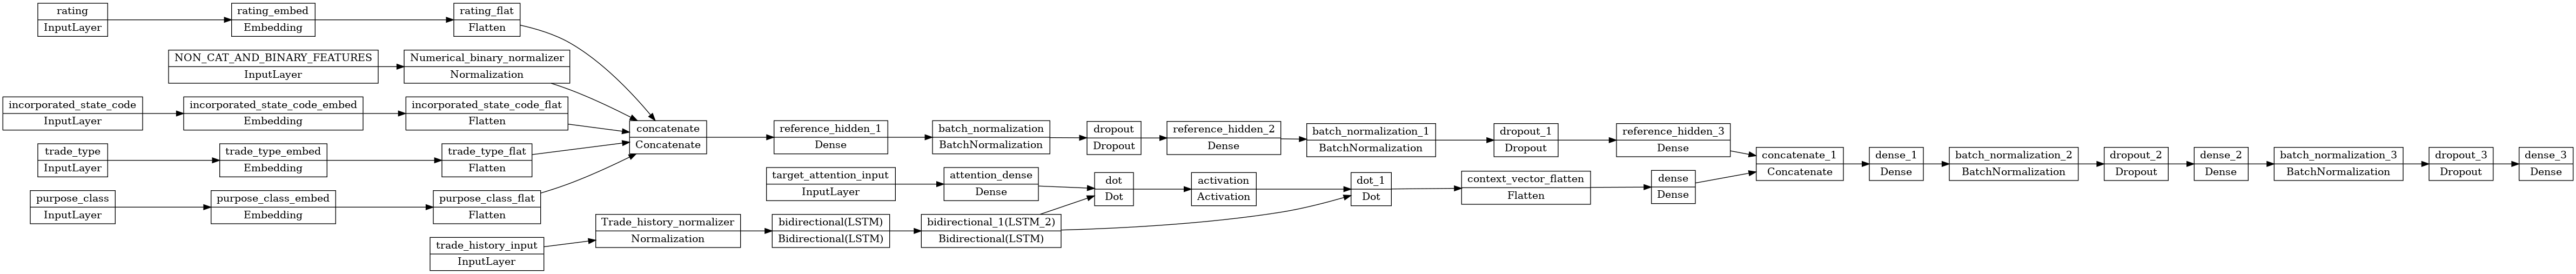

In [125]:
keras.utils.plot_model(dysabs_model, rankdir='LR')

In [126]:
input_layers = dysabs_model.input
input_layers_dict = dict(zip([x.name for x in input_layers], input_layers))

In [127]:
input_layers_dict

{'trade_history_input': <KerasTensor: shape=(None, 5, 6) dtype=float32 (created by layer 'trade_history_input')>,
 'target_attention_input': <KerasTensor: shape=(None, 1, 3) dtype=float32 (created by layer 'target_attention_input')>,
 'NON_CAT_AND_BINARY_FEATURES': <KerasTensor: shape=(None, 26) dtype=float32 (created by layer 'NON_CAT_AND_BINARY_FEATURES')>,
 'rating': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'rating')>,
 'incorporated_state_code': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'incorporated_state_code')>,
 'trade_type': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'trade_type')>,
 'purpose_class': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'purpose_class')>}

In [7]:
def generate_meta_model(secondary_model, input_layers_dict, input_layers, TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []

    trade_history_input = input_layers_dict['trade_history_input'] 

    target_attention_input = input_layers_dict['target_attention_input'] 

    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(input_layers_dict['NON_CAT_AND_BINARY_FEATURES'])
    # inputs.append(dysabs_model(input_layers))

    layer.append(noncat_binary_normalizer(inputs[2]))
    layer.append(secondary_model(input_layers)) #to connect the two models to the same input layers, we must add dysabs_model to the concatenated input of the meta model by calling dysabs_model(inputs)
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(input_layers_dict['trade_history_input']))
    features = lstm_layer_2(features)  


    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)


    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:

        fin = input_layers_dict[f]
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=[final, secondary_model(input_layers)])
    
    return model 

In [155]:
model = (dysabs_model, input_layers_dict, TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)

In [129]:
mae_loss = keras.losses.MeanAbsoluteError()

In [138]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=[mae_loss, mae_loss])

Keras obscures this in the plot, but the dysabs_model is encapsulated in a 'Functional' node though it is an entire model with the exact same architecture.

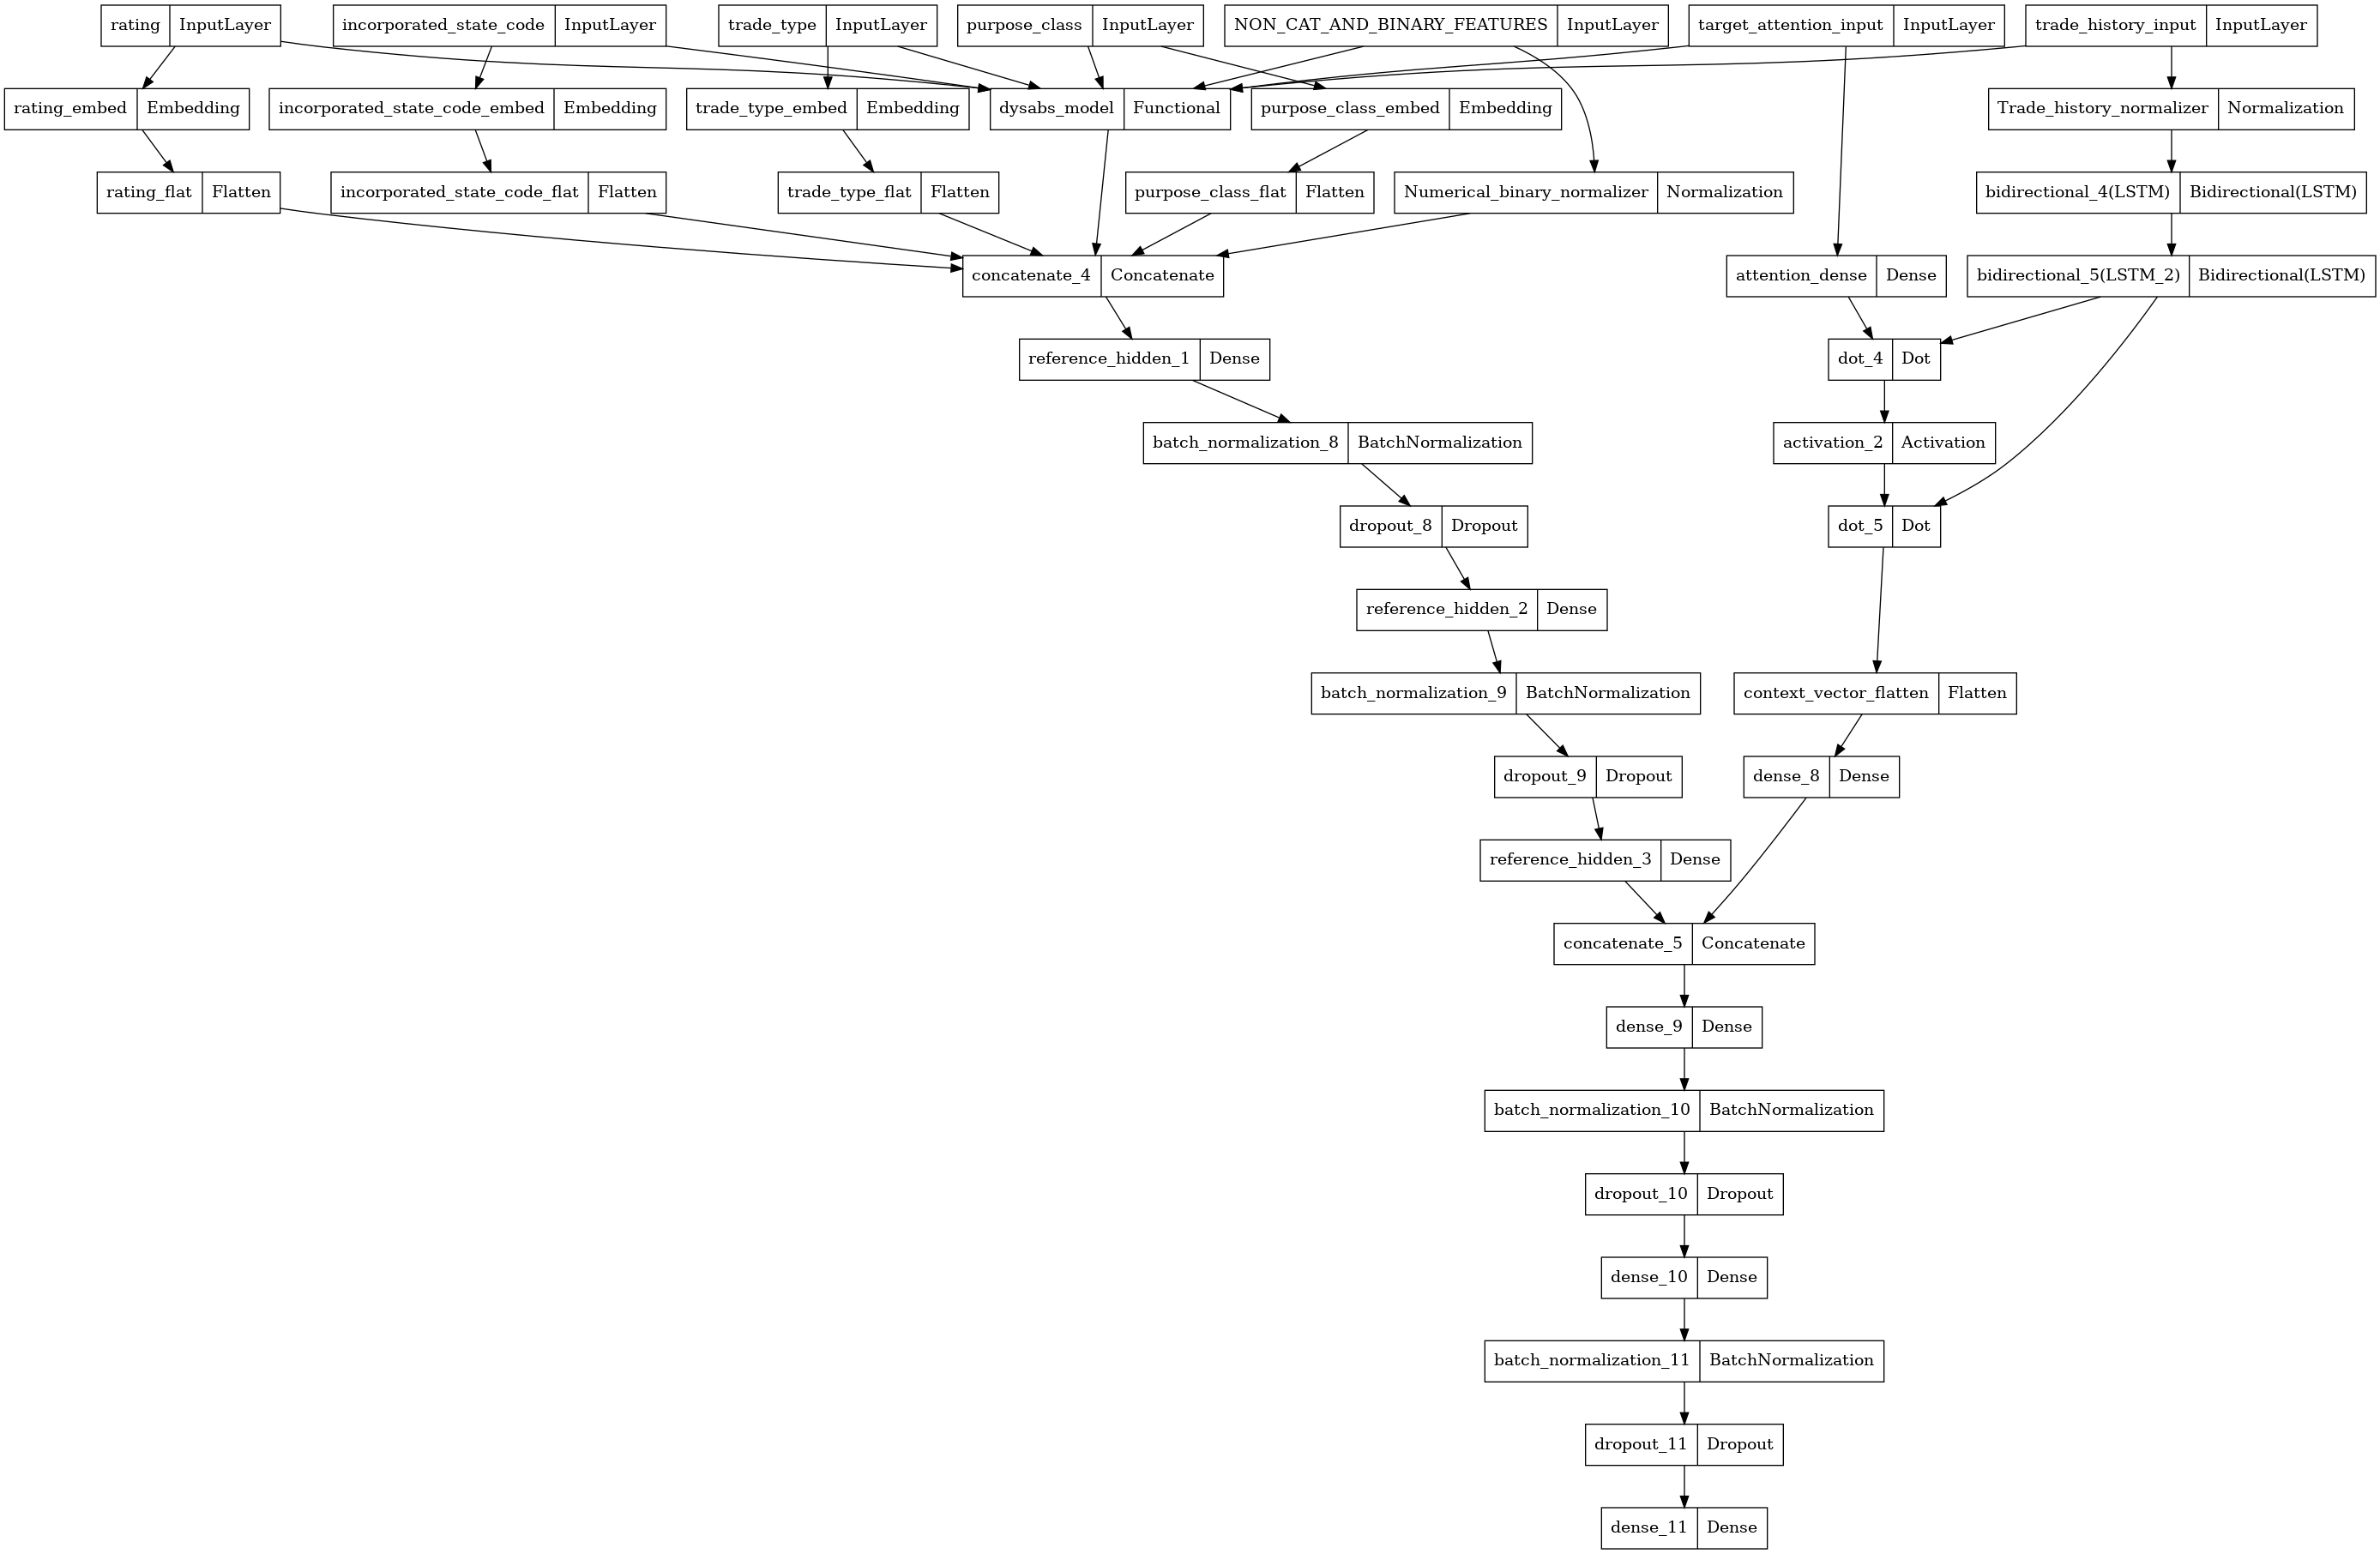

In [139]:
keras.utils.plot_model(model)

In [140]:
fit_callbacks = [
                keras.callbacks.EarlyStopping(
                monitor="val_loss",
                patience=10,
                verbose=0,
                mode="auto",
                restore_best_weights=True),
                ]
    
# with tf.device('/cpu:0'):
#     train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
#     train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
#     val_ds = create_tf_data(x_val, y_val, shuffle = False)
#     val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()

# history= model.fit(train_ds,
#                   validation_data=val_ds,
#                     epochs=NUM_EPOCHS,     
#                     verbose=1, 
#                     callbacks=fit_callbacks,
#                     use_multiprocessing=True,
#                     workers=8)

history= model.fit(x_train, 
                   y_train, #note that y_train here is of shape (N, 2), where the first column is diff_ys and the second is dysabs
                   validation_split=0.1,
                   epochs=NUM_EPOCHS,
                   batch_size=BATCH_SIZE,
                   verbose=1, 
                   callbacks=fit_callbacks,
                   use_multiprocessing=True,
                   workers=8)

Epoch 1/75


2023-09-19 18:24:27.645847: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-19 18:24:27.646052: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

649/649 [==============================] - ETA: 0s - loss: 24.3807 - dense_11_loss: 12.5817 - dysabs_model_loss: 11.7991

2023-09-19 18:24:52.324144: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-19 18:24:52.324339: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

649/649 [==============================] - 51s 37ms/step - loss: 24.3807 - dense_11_loss: 12.5817 - dysabs_model_loss: 11.7991 - val_loss: 24.3512 - val_dense_11_loss: 12.5747 - val_dysabs_model_loss: 11.7765
Epoch 2/75
649/649 [==============================] - 30s 46ms/step - loss: 23.5024 - dense_11_loss: 11.9892 - dysabs_model_loss: 11.5133 - val_loss: 23.2867 - val_dense_11_loss: 11.8624 - val_dysabs_model_loss: 11.4243
Epoch 3/75
649/649 [==============================] - 19s 30ms/step - loss: 22.9593 - dense_11_loss: 11.5890 - dysabs_model_loss: 11.3702 - val_loss: 23.0944 - val_dense_11_loss: 11.6771 - val_dysabs_model_loss: 11.4173
Epoch 4/75
649/649 [==============================] - 20s 31ms/step - loss: 22.6037 - dense_11_loss: 11.3309 - dysabs_model_loss: 11.2728 - val_loss: 22.7695 - val_dense_11_loss: 11.4034 - val_dysabs_model_loss: 11.3661
Epoch 5/75
649/649 [==============================] - 28s 44ms/step - loss: 22.4296 - dense_11_loss: 11.2158 - dysabs_model_loss: 1

In [141]:
preds = model.predict(x_test, batch_size=5000)

2023-09-19 18:47:36.053833: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-19 18:47:36.053990: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [149]:
mean_absolute_error(preds[0], y_test[:,0]), mean_absolute_error(preds[1], y_test[:,1])

(12.298174769729592, 10.281504227173633)

# Full Experiment

In [8]:
%time processed_data = load_data_from_pickle('processed_data_2023-08-21-14:53.pkl', bucket = 'ficc_training_data_latest')

File available, loading pickle
CPU times: user 26.2 s, sys: 9 s, total: 35.2 s
Wall time: 1min 6s


In [10]:
processed_data.trade_date.min(), processed_data.trade_date.max()

(Timestamp('2023-01-03 00:00:00'), Timestamp('2023-08-15 00:00:00'))

In [11]:
processed_data.sort_values('trade_datetime', inplace=True)

In [12]:
processed_data.reset_index(drop=True, inplace=True)

In [ ]:
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))

In [ ]:
ttype_dict = { (0,0):'D', (0,1):'S', (1,0):'P' }

ys_variants = ["max_ys", "min_ys", "max_qty", "min_ago", "D_min_ago", "P_min_ago", "S_min_ago"]
ys_feats = ["_ys", "_ttypes", "_ago", "_qdiff"]
D_prev = dict()
P_prev = dict()
S_prev = dict()

def get_trade_history_columns():
    '''
    This function is used to create a list of columns
    '''
    YS_COLS = []
    for prefix in ys_variants:
        for suffix in ys_feats:
            YS_COLS.append(prefix + suffix)
    return YS_COLS

def extract_feature_from_trade(row, name, trade):
    yield_spread = trade[0]
    ttypes = ttype_dict[(trade[3],trade[4])] + row.trade_type
    seconds_ago = trade[5]
    diff = 10**trade[2] - 10**row.quantity
    quantity_diff = np.sign(diff) * np.log10(1 + np.abs(diff))
    return [yield_spread, ttypes,  seconds_ago, quantity_diff]

def trade_history_derived_features(row):
    trade_history = row.trade_history
    trade = trade_history[0]
    
    D_min_ago_t = D_prev.get(row.cusip,trade)
    D_min_ago = 9        

    P_min_ago_t = P_prev.get(row.cusip,trade)
    P_min_ago = 9
    
    S_min_ago_t = S_prev.get(row.cusip,trade)
    S_min_ago = 9
    
    max_ys_t = trade; max_ys = trade[0]
    min_ys_t = trade; min_ys = trade[0]
    max_qty_t = trade; max_qty = trade[2]
    min_ago_t = trade; min_ago = trade[5]
    
    for trade in trade_history[0:]:
        #Checking if the first trade in the history is from the same block
        if trade[5] == 0: 
            continue
 
        if trade[0] > max_ys: 
            max_ys_t = trade
            max_ys = trade[0]
        elif trade[0] < min_ys: 
            min_ys_t = trade; 
            min_ys = trade[0]

        if trade[2] > max_qty: 
            max_qty_t = trade 
            max_qty = trade[2]
        if trade[5] < min_ago: 
            min_ago_t = trade; 
            min_ago = trade[5]
            
        side = ttype_dict[(trade[3],trade[4])]
        if side == "D":
            if trade[5] < D_min_ago: 
                D_min_ago_t = trade; D_min_ago = trade[5]
                D_prev[row.cusip] = trade
        elif side == "P":
            if trade[5] < P_min_ago: 
                P_min_ago_t = trade; P_min_ago = trade[5]
                P_prev[row.cusip] = trade
        elif side == "S":
            if trade[5] < S_min_ago: 
                S_min_ago_t = trade; S_min_ago = trade[5]
                S_prev[row.cusip] = trade
        else: 
            print("invalid side", trade)
    
    trade_history_dict = {"max_ys":max_ys_t,
                          "min_ys":min_ys_t,
                          "max_qty":max_qty_t,
                          "min_ago":min_ago_t,
                          "D_min_ago":D_min_ago_t,
                          "P_min_ago":P_min_ago_t,
                          "S_min_ago":S_min_ago_t}

    return_list = []
    for variant in ys_variants:
        feature_list = extract_feature_from_trade(row,variant,trade_history_dict[variant])
        return_list += feature_list
    
    return return_list

In [ ]:
%%time
temp = processed_data[['cusip','trade_history','quantity','trade_type']].parallel_apply(trade_history_derived_features, axis=1)
YS_COLS = get_trade_history_columns()
processed_data[YS_COLS] = pd.DataFrame(temp.tolist(), index=processed_data.index)

In [ ]:
%%time
processed_data['ttypes'] = (processed_data.last_trade_type.astype(str) + processed_data.trade_type.astype(str)).astype('category')
processed_data['diff_size'] = (processed_data.par_traded.astype(float) - processed_data.last_size).astype(np.float32)

processed_data['last_yield_spread_missing'] = processed_data['last_yield_spread'].isna()
processed_data['last_seconds_ago_missing'] = processed_data['last_seconds_ago'].isna()

# processed_data['last_yield_spread'] = processed_data['last_yield_spread'].fillna(0)
# processed_data['last_seconds_ago'] = processed_data['last_seconds_ago'].fillna(0)

# processed_data['abs_last_yield_spread'] = np.abs(processed_data['last_yield_spread'])
# processed_data['abs_diff_size'] = np.abs(processed_data['diff_size'])
# processed_data['days_duration'] = (processed_data.last_calc_date - processed_data.last_settlement_date).dt.days

In [ ]:
%%time
processed_data['trade_history_sum'] = processed_data.trade_history.parallel_apply(lambda x: np.sum(x))
processed_data = processed_data.dropna(subset=['trade_history_sum'])
processed_data.purpose_sub_class.fillna(0, inplace=True)

In [ ]:
for col in ['new_ficc_ycl', 'yield_spread']:
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)
    if col in PREDICTORS:
        PREDICTORS.remove(col)

In [ ]:
def modify_features(cols, how, where=None):
    global CATEGORICAL_FEATURES, PREDICTORS, NON_CAT_FEATURES, BINARY
    
    if how not in ['add','remove']:
        raise ValueError("'how' argument must be one off the following: ['add','remove']")
        
    if where not in ['categorical','binary', 'numeric']:
        raise ValueError("'where' argument must be one off the following: ['categorical','binary', 'numeric']")
    
    if not isinstance(cols, list):
        raise TypeError(f"'cols' argument must be a list, received {type(cols)}")
    
        
    if how == 'remove':
        for col in cols: 
            if col in CATEGORICAL_FEATURES:
                CATEGORICAL_FEATURES.remove(col)
            if col in BINARY:
                BINARY.remove(col)
            if col in NON_CAT_FEATURES:
                NON_CAT_FEATURES.remove(col)
            if col in PREDICTORS:
                PREDICTORS.remove(col)
            
    if how == 'add':
        for col in cols: 
            if col not in CATEGORICAL_FEATURES and where=='categorical':
                CATEGORICAL_FEATURES.append(col)
            if col not in BINARY and where=='binary':
                BINARY.append(col)
            if col not in NON_CAT_FEATURES and where=='numeric':
                NON_CAT_FEATURES.append(col)
            if col not in PREDICTORS:
                PREDICTORS.append(col)

## Further Processing

In [ ]:
additional_features = ['ttypes', 'diff_size', 'abs_last_yield_spread', 'abs_diff_size', 'days_duration']
YS_COLS = ['max_ys_ys', 'max_ys_ttypes', 'max_ys_ago', 'max_ys_qdiff', 'min_ys_ys', 'min_ys_ttypes', 'min_ys_ago', 'min_ys_qdiff', 'max_qty_ys', 'max_qty_ttypes', \
           'max_qty_ago', 'max_qty_qdiff', 'min_ago_ys', 'min_ago_ttypes', 'min_ago_ago', 'min_ago_qdiff', 'D_min_ago_ys', 'D_min_ago_ttypes', 'D_min_ago_ago', 'D_min_ago_qdiff',\
           'P_min_ago_ys', 'P_min_ago_ttypes', 'P_min_ago_ago', 'P_min_ago_qdiff', 'S_min_ago_ys', 'S_min_ago_ttypes', 'S_min_ago_ago', 'S_min_ago_qdiff']
    
for col in YS_COLS:
    if 'ttypes' in col and col not in PREDICTORS:
        PREDICTORS.append(col)
        CATEGORICAL_FEATURES.append(col)
    elif col not in PREDICTORS:
        NON_CAT_FEATURES.append(col)
        PREDICTORS.append(col)
        
if 'target_attention_features' not in PREDICTORS:
    PREDICTORS.append('target_attention_features')
    
if 'ficc_treasury_spread' not in PREDICTORS:
    PREDICTORS.append('ficc_treasury_spread')
    NON_CAT_FEATURES.append('ficc_treasury_spread')
    
#these harm accuracy so we delete them 
for col in ['new_ficc_ycl', 'new_real_time_ficc_ycl']:     
    if col in PREDICTORS:
        PREDICTORS.remove(col)
    if col in NON_CAT_FEATURES:
        NON_CAT_FEATURES.remove(col)

encoders = {}
fmax = {}
for f in CATEGORICAL_FEATURES:
    print(f)
    if f in ['rating', 'incorporated_state_code', 'trade_type', 'purpose_class']:
        fprep = preprocessing.LabelEncoder().fit(categorical_feature_values[f])
    else:
        fprep = preprocessing.LabelEncoder().fit(processed_data[f].drop_duplicates())
    fmax[f] = np.max(fprep.transform(fprep.classes_))
    encoders[f] = fprep
    
with open('encoders.pkl','wb') as file:
    pickle.dump(encoders,file)

In [ ]:
%%time
TRADE_SEQUENCE_LENGTH = 5 
processed_data['trade_history_shortened'] = processed_data['trade_history'].apply(lambda x: x[:TRADE_SEQUENCE_LENGTH])

In [ ]:
processed_data.trade_date.min(), processed_data.trade_date.max(), len(processed_data)

In [ ]:
processed_data.sort_values('trade_datetime',ascending=False,inplace=True)

In [ ]:
processed_data['diff_ys'] = processed_data['new_ys'] - processed_data['last_yield_spread'] 
processed_data['diff_ys_abs'] = abs(processed_data['diff_ys'])

In [66]:
processed_data.dropna(subset=PREDICTORS + [target_variable, 'trade_history_sum'], inplace=True)

### Model and Data Preparation Code

In [32]:
def create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col):
    
    if not isinstance(trade_history_col, str):
        raise ValueError('trade_history_col must be a string')
    
    TRADE_SEQUENCE_LENGTH = train_dataframe[trade_history_col][0].shape[0] 
    
    params = {'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH}
    
    np.random.seed(1)
    val_idx = np.random.choice(range(len(train_dataframe)), 
                     size = int(VALIDATION_SPLIT*len(train_dataframe)),
                     replace=False)

    print(f'TRAINING DATA: N = {len(train_dataframe)-len(val_idx)}, MIN DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.min()}, MAX DATE = {train_dataframe.drop(val_idx, axis=0).trade_date.max()}')
    print(f'VALIDATION DATA: N = {len(val_idx)}, MIN DATE = {train_dataframe.iloc[val_idx].trade_date.min()}, MAX DATE = {train_dataframe.iloc[val_idx].trade_date.max()}')
    print(f'TEST DATA: N = {len(test_dataframe)}, MIN DATE = {test_dataframe.trade_date.min()}, MAX DATE = {test_dataframe.trade_date.max()}')

    x_train = create_input_new(train_dataframe.drop(val_idx, axis=0), trade_history_col)
    y_train = train_dataframe.drop(val_idx, axis=0)[[TARGET, secondary_target]].values

    x_val = create_input_new(train_dataframe.iloc[val_idx], trade_history_col)
    y_val = train_dataframe.iloc[val_idx][[TARGET, secondary_target]].values

    x_test = create_input_new(test_dataframe, trade_history_col)
    y_test = test_dataframe[[TARGET, secondary_target]].values  
    
    with tf.device('/cpu:0'):
        # Normalization layer for the trade history
        trade_history_normalizer = Normalization(name='Trade_history_normalizer')
        trade_history_normalizer.adapt(x_train[0],batch_size=BATCH_SIZE)

        # Normalization layer for the non-categorical and binary features
        noncat_binary_normalizer = Normalization(name='Numerical_binary_normalizer')
        noncat_binary_normalizer.adapt(x_train[2], batch_size = BATCH_SIZE)

    normalizers = {'trade_history_normalizer': trade_history_normalizer,
                  'noncat_binary_normalizer': noncat_binary_normalizer}

    return  params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx


def create_tf_data(x_train, y_train, shuffle=False, shuffle_buffer=1):
                     
    X=()
    for x in x_train:
        X += (tf.data.Dataset.from_tensor_slices(x),)
        

    temp = tf.data.Dataset.zip((X))
    del X
    dataset = tf.data.Dataset.zip((temp,
                        tf.data.Dataset.from_tensor_slices(y_train)))
    del temp
    if shuffle:
        shuffle_buffer = int(len(x_train[0])*shuffle_buffer)
        dataset = dataset.shuffle(shuffle_buffer)
        
    return dataset


In [33]:
def log_experiment(experiment_dir, parameters, model):
    if not os.path.isdir(experiment_dir):
        print(f'{experiment_dir} does not exist. Creating now')
        os.makedirs(experiment_dir)
    
    if not os.path.isdir(os.path.join(experiment_dir, 'model')):
        os.makedirs(os.path.join(experiment_dir, 'model'))
    
    parameters_path = os.path.join(experiment_dir, 'parameters.json')
    
    with open(parameters_path, 'w') as metadata_file:
        json.dump(parameters, metadata_file)

    i = 0
    model_path = f'model/model_{i}'
    while os.path.isdir(os.path.join(experiment_dir, model_path)):
        i+=1
        model_path = f'model/model_{i}'
    model.save(os.path.join(experiment_dir, model_path))
    print(f'Model saved to {os.path.join(experiment_dir, model_path)}')
    
def run_experiment(n_runs):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    experiment_dir = f'two_tower_experiments/{target_variable}_experiment_{timestamp}'

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
    
    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'TARGET':TARGET,
                    'secondary_target':secondary_target,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')


    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        tf.keras.backend.clear_session()
        
        dysabs_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        dysabs_model._name = 'dysabs_model'
        
        input_layers = dysabs_model.input
        input_layers_dict = dict(zip([x.name for x in input_layers], input_layers))
        
        model = generate_meta_model(dysabs_model, input_layers_dict, input_layers, TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=[mae_loss, mae_loss], loss_weights = [1, 0])

        history= model.fit(train_ds,
                                          validation_data=val_ds,
                                            epochs=NUM_EPOCHS,     
                                            verbose=1, 
                                            callbacks=fit_callbacks,
                                            use_multiprocessing=True,
                                            workers=8)
        
        # pred = model.predict(x_test, batch_size=5000)
        # predictions.append(pred)
        # print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
#     with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
#         pickle.dump(predictions, f)
        
#     with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
#         pickle.dump([x[0] for x in results], f)
        
    return results

In [29]:
train_start = '2023-02-01'
train_end = '2023-07-01'
test_start = '2023-07-01'
test_end = '2023-08-01'
VALIDATION_SPLIT = 0.1

In [36]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)

train_dataframe = processed_data[train_filter].sort_values(by='trade_date', ascending=True).reset_index(drop=True)

test_dataframe = processed_data[test_filter].sort_values(by='trade_date', ascending=True).reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col)

Training data start: 2023-02-01 00:00:00, end: 2023-06-30 00:00:00
Test data start: 2023-07-03 00:00:00, end: 2023-07-31 00:00:00
TRAINING DATA: N = 3357804, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 373089, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 710895, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


2023-09-21 17:25:24.827435: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 17:25:24.831094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 17:25:24.832762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 17:25:24.834061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [206]:
fit_callbacks = [
keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True),
    ]

In [ ]:
shuffle_buffer = .75
shuffle = True
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
LEARNING_RATE = 0.0002

ytw_result = run_experiment(1)

Experiment results will be saved to two_tower_experiments/diff_ys_experiment_2023-09-20_16:25

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3705550, 'test_size': 707212, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0002, 'BATCH_SIZE': 1000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'TARGET': 'diff_ys', 'secondary_target': 'diff_ys_abs', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_pay

2023-09-20 23:26:22.691019: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-20 23:26:22.691202: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

3335/3335 [==============================] - ETA: 0s - loss: 15.2305 - dense_7_loss: 15.2305 - dysabs_model_loss: 18.3434

2023-09-20 23:30:44.666951: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 14254866432 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-20 23:30:44.667078: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

3335/3335 [==============================] - 292s 66ms/step - loss: 15.2305 - dense_7_loss: 15.2305 - dysabs_model_loss: 18.3434 - val_loss: 14.5655 - val_dense_7_loss: 14.5655 - val_dysabs_model_loss: 18.3937
Epoch 2/150
3335/3335 [==============================] - 215s 64ms/step - loss: 14.5808 - dense_7_loss: 14.5808 - dysabs_model_loss: 18.4352 - val_loss: 14.3651 - val_dense_7_loss: 14.3651 - val_dysabs_model_loss: 18.5324
Epoch 3/150
3335/3335 [==============================] - 185s 56ms/step - loss: 14.4407 - dense_7_loss: 14.4407 - dysabs_model_loss: 18.5176 - val_loss: 14.2935 - val_dense_7_loss: 14.2935 - val_dysabs_model_loss: 18.5819
Epoch 4/150
3335/3335 [==============================] - 200s 60ms/step - loss: 14.3544 - dense_7_loss: 14.3544 - dysabs_model_loss: 18.5719 - val_loss: 14.2419 - val_dense_7_loss: 14.2419 - val_dysabs_model_loss: 18.6632
Epoch 5/150
3335/3335 [==============================] - 213s 64ms/step - loss: 14.2952 - dense_7_loss: 14.2952 - dysabs_mod

In [247]:
pred = ytw_result[0][1].predict(x_test, batch_size=5000)

In [248]:
mean_absolute_error(y_test[:,0], pred[0])

14.597289465379857

In [ ]:
def addflag(flag, condition, name):
    empty = flag == "none"
    flag[condition & empty] = name
    flag[condition & ~empty] = flag[condition & ~empty] + " & " + name
    
def addcol(data, newname, newvals, warn=False):
    if newname in data.columns:
        if warn: print( f"Warning: replacing duplicate column {newname}" )
        data[newname] = newvals
    else:
        newcol = pd.Series(newvals, index = data.index, name=newname)
        data = pd.concat([data,newcol],axis=1)
    return data

def mkcases(df):
    flag = pd.Series("none", index=df.index)

    addflag(flag, df.last_yield.isna(), "no last yld")
    addflag(flag, df.last_yield < 150, "last yld < 1.5%")
    addflag(flag, df.last_yield.between(150,700), "1.5% <= last yld <= 7%")
    addflag(flag, df.last_yield > 700, "last yld > 7%")
    addflag(flag, df.when_issued, "when issued")
    
    print( flag.value_counts(dropna=False) )
    return flag.astype('category')

def mean_absolute_deviation(pred, truth):
    pred, truth = np.array(pred).reshape(-1,1), np.array(truth).reshape(-1,1)
    err = abs(pred - truth)
    return np.median(err)

def compare_mae(df, prediction_cols, groupby_cols, target_variable):
    
    if not isinstance(prediction_cols, list):
        raise TypeError(f'prediction_cols must be a list, got {type(prediction_cols)}, {type(groupby_cols)} instead')
    
    if groupby_cols and not isinstance(groupby_cols, list):
        raise TypeError(f'groupby_cols must be a list or None, got {type(groupby_cols)} instead')
    
    print(f'{f" Analysis for target: {target_variable} ":=^75}')
    
    nan_counts = df[prediction_cols].isna().sum() 
    
    for x,y  in df[prediction_cols].isna().sum().iteritems():
        print(f'Prediction col {x} has {y} nan values')
    
    df = df.dropna(subset=prediction_cols)

    if groupby_cols:
        temp = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp = pd.DataFrame(temp.to_list(), index = zip(['Overall']*len(temp),temp.index))

        temp2 = df[[target_variable, 'cases'] + prediction_cols + groupby_cols]\
                .groupby(['cases']+ groupby_cols, observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        summary = pd.concat([temp, temp2], axis=0)

    else:
        
        temp2 = df[[target_variable, 'cases'] + prediction_cols]\
                .groupby('cases', observed=True)\
                .apply(lambda x: [mean_absolute_error(x[target_variable], x[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(x[target_variable], x[col]) for col in prediction_cols] + [len(x)])   
        temp2 = pd.DataFrame(temp2.to_list(), index = temp2.index)
        
        temp = pd.DataFrame([mean_absolute_error(df[target_variable], df[col]) for col in prediction_cols] + \
                        [mean_absolute_deviation(df[target_variable], df[col]) for col in prediction_cols] + [len(df)], columns=['Overall']).T
    
    summary = pd.concat([temp, temp2], axis=0)  
    mae_col = ['MAE']*len(prediction_cols)
    mad_col = ['MAD']*len(prediction_cols)
    columns= list(zip(mae_col, prediction_cols)) + list(zip(mad_col, prediction_cols)) + [('', 'N')]
    summary.columns=pd.MultiIndex.from_tuples(columns)
    
    if groupby_cols:
        summary.index=pd.MultiIndex.from_tuples(summary.index, names = ['cases']+groupby_cols)
    else:
        pass
    
    summary[('', 'N')] = summary[('', 'N')].astype(int)
    return summary

def add_ago_cases(data):
    no_last = (data['last_minute_ago'] <= 0)
    last_minute = (data['last_minute_ago'] <= 1) & (data['last_minute_ago'] > 0)
    last_hour = (data['last_minute_ago'] > 1) & (data['last_minute_ago'] <= 60)
    last_day = (data['last_minute_ago'] > 60) & (data['last_minute_ago'] <= 60 * 24)
    last_week = (data['last_minute_ago'] > 60 * 24) & (data['last_minute_ago'] <= 60 * 24 * 7)
    last_month = (data['last_minute_ago'] > 60 * 24 * 7) & (data['last_minute_ago'] <= 60 * 24 * 7 * 30)
    last_year = (data['last_minute_ago'] > 60 * 24 * 7 * 30) & (data['last_minute_ago'] <= 60 * 24 * 7 * 30 * 12)

    beyond_year = ~no_last
    for cond in [last_minute, last_hour, last_day, last_week, last_month, last_year]:
        beyond_year = beyond_year & (~cond)

    conds = zip(['no_last', 'last_minute', 'last_hour', 'last_day', 'last_week', 'last_month', 'last_year', 'beyond_year'], 
               [no_last, last_minute, last_hour, last_day, last_week, last_month, last_year, beyond_year])

    for name, cond in conds:
        data.loc[cond, 'last_trade_case'] = name
        
    return data 

# Reworked Model Code

In [68]:
def generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, DROPOUT):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))



    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  
    
    
    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)
    
 
    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:
        
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)


    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])
    
    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=final)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
          loss=keras.losses.MeanAbsoluteError())
    
    return model
    


In [81]:
def generate_meta_model(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer):
    inputs = []
    layer = []
    
    trade_history_input = layers.Input(name="trade_history_input", 
                                       shape=(TRADE_SEQUENCE_LENGTH, NUM_FEATURES), 
                                       dtype = tf.float32) 

    target_attention_input = layers.Input(name="target_attention_input", 
                                       shape=(1, 3), 
                                       dtype = tf.float32) 
    inputs.append(trade_history_input)
    inputs.append(target_attention_input)

    inputs.append(layers.Input(
        name="NON_CAT_AND_BINARY_FEATURES",
        shape=(len(NON_CAT_FEATURES + BINARY),)
    ))


    layer.append(noncat_binary_normalizer(inputs[2]))
    ####################################################


    ############## TRADE HISTORY MODEL #################

    lstm_layer = layers.Bidirectional(layers.LSTM(50, 
                             activation='tanh',
                             input_shape=(TRADE_SEQUENCE_LENGTH,NUM_FEATURES),
                             return_sequences = True,
                             name='LSTM'))

    lstm_layer_2 = layers.Bidirectional(layers.LSTM(100, 
                                                    activation='tanh',
                                                    input_shape=(TRADE_SEQUENCE_LENGTH, 50),
                                                    return_sequences = True,
                                                    name='LSTM_2'))

    features = lstm_layer(trade_history_normalizer(inputs[0]))
    features = lstm_layer_2(features)  


    attention_sequence = layers.Dense(200, activation='relu', name='attention_dense')(target_attention_input)
    attention = layers.Dot(axes=[2, 2])([features, attention_sequence])
    attention = layers.Activation('softmax')(attention)

    context_vector = layers.Dot(axes=[1, 1])([features, attention])
    context_vector = layers.Flatten(name='context_vector_flatten')(context_vector)


    trade_history_output = layers.Dense(100, 
                                        activation='relu')(context_vector)


    ####################################################

    ############## REFERENCE DATA MODEL ################
    global encoders
    for f in CATEGORICAL_FEATURES:

        # fin = input_layers_dict[f]
        fin = layers.Input(shape=(1,), name = f)
        inputs.append(fin)
        embedded = layers.Flatten(name = f + "_flat")( layers.Embedding(input_dim = fmax[f],
                                                                        output_dim = max(30,int(np.sqrt(fmax[f]))),
                                                                        input_length= 1,
                                                                        name = f + "_embed")(fin))
        layer.append(embedded)

        
        
        
        
    #### INSERT DYSABS MODEL ####
    secondary_model = generate_model_default(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer, 0.25)
    layer.append(secondary_model(inputs)) #to connect the two models to the same input layers, we must add dysabs_model to the concatenated input of the meta model by calling dysabs_model(inputs)
    
    reference_hidden = layers.Dense(400,
                                    activation='relu',
                                    name='reference_hidden_1')(layers.concatenate(layer, axis=-1))
    reference_hidden = layers.BatchNormalization()(reference_hidden)
    reference_hidden = layers.Dropout(DROPOUT)(reference_hidden)

    reference_hidden2 = layers.Dense(200,activation='relu',name='reference_hidden_2')(reference_hidden)
    reference_hidden2 = layers.BatchNormalization()(reference_hidden2)
    reference_hidden2 = layers.Dropout(DROPOUT)(reference_hidden2)

    reference_output = layers.Dense(100,activation='relu',name='reference_hidden_3')(reference_hidden2)
    ####################################################

    feed_forward_input = layers.concatenate([reference_output, trade_history_output])

    hidden = layers.Dense(300,activation='relu')(feed_forward_input)
    hidden = layers.BatchNormalization()(hidden)
    hidden = layers.Dropout(DROPOUT)(hidden)

    hidden2 = layers.Dense(100,activation='relu')(hidden)
    hidden2 = layers.BatchNormalization()(hidden2)
    hidden2 = layers.Dropout(DROPOUT)(hidden2)

    final = layers.Dense(1)(hidden2)

    model = keras.Model(inputs=inputs, outputs=[final, secondary_model(inputs)])
    
    return model 

def run_experiment(n_runs):
    tz=pytz.timezone('US/Pacific')
    timestamp = datetime.now(tz).strftime("%Y-%m-%d_%H:%M")
    results = []
    predictions = []
    experiment_dir = f'two_tower_experiments/{target_variable}_experiment_{timestamp}'

    TRADE_SEQUENCE_LENGTH = params.get('TRADE_SEQUENCE_LENGTH')
    trade_history_normalizer = normalizers.get('trade_history_normalizer')
    noncat_binary_normalizer = normalizers.get('noncat_binary_normalizer')
    
    parameters = {'train_start':train_start,
                    'train_end':train_end,
                    'test_start':test_start,
                    'test_end':test_end,
                    'train_size':len(train_dataframe),
                    'test_size':len(test_dataframe),
                    'VALIDATION_SPLIT':VALIDATION_SPLIT,
                    'LEARNING_RATE':LEARNING_RATE,
                    'BATCH_SIZE':BATCH_SIZE,
                    'NUM_EPOCHS':NUM_EPOCHS,
                    'DROPOUT':DROPOUT,
                    'TRADE_SEQUENCE_LENGTH':TRADE_SEQUENCE_LENGTH,
                    'NUM_FEATURES':NUM_FEATURES,
                    'TARGET':TARGET,
                    'secondary_target':secondary_target,
                    'features':BINARY+NON_CAT_FEATURES+CATEGORICAL_FEATURES,
                    'shuffle_buffer':shuffle_buffer,
                    'use_bottleneck_model':use_bottleneck_model}
 
    print(f'Experiment results will be saved to {experiment_dir}\n')
    print(f'Performing {n_runs} runs with parameters: {parameters}')


    with tf.device('/cpu:0'):
        train_ds = create_tf_data(x_train, y_train, shuffle, shuffle_buffer)
        train_ds = train_ds.batch(BATCH_SIZE).prefetch(2).cache()
        val_ds = create_tf_data(x_val, y_val, shuffle = False)
        val_ds = val_ds.batch(BATCH_SIZE).prefetch(2).cache()
    
    for i in range(n_runs):
        tf.keras.utils.set_random_seed(10)
        tf.keras.backend.clear_session()
        
        mae_loss = keras.losses.MeanAbsoluteError()
        model = generate_meta_model(TRADE_SEQUENCE_LENGTH, trade_history_normalizer, noncat_binary_normalizer)
        model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=[mae_loss, mae_loss], loss_weights = [1, 0.5])

        history= model.fit(train_ds,
                                          validation_data=val_ds,
                                            epochs=NUM_EPOCHS,     
                                            verbose=1, 
                                            callbacks=fit_callbacks,
                                            use_multiprocessing=True,
                                            workers=8)
        
        # pred = model.predict(x_test, batch_size=5000)
        # predictions.append(pred)
        # print('='*25+f' TRIAL {i}, MAE: {mean_absolute_error(pred,y_test)} '+'='*25)
        results.append([history, model])
        log_experiment(experiment_dir, parameters, model)
    
#     with open(os.path.join(experiment_dir, 'predictions.pkl'), 'wb') as f: 
#         pickle.dump(predictions, f)
        
#     with open(os.path.join(experiment_dir, 'results.pkl'), 'wb') as f: 
#         pickle.dump([x[0] for x in results], f)
        
    return results

In [70]:
train_start = '2023-02-01'
train_end = '2023-07-01'
test_start = '2023-07-01'
test_end = '2023-08-01'
VALIDATION_SPLIT = 0.1

In [71]:
train_filter = (processed_data.trade_date < train_end) & (processed_data.trade_date >= train_start)
test_filter = (processed_data.trade_date >= test_start) & (processed_data.trade_date <test_end)

train_dataframe = processed_data[train_filter].sort_values(by='trade_date', ascending=True).reset_index(drop=True)

test_dataframe = processed_data[test_filter].sort_values(by='trade_date', ascending=True).reset_index(drop=True)

print('Training data start: {}, end: {}'.format(train_dataframe.trade_date.min(),train_dataframe.trade_date.max()))
print('Test data start: {}, end: {}'.format(test_dataframe.trade_date.min(),test_dataframe.trade_date.max()))

params, normalizers, x_train, y_train, x_val, y_val, x_test, y_test, val_idx = create_data_set_and_model(train_dataframe, test_dataframe, trade_history_col)

Training data start: 2023-02-01 00:00:00, end: 2023-06-30 00:00:00
Test data start: 2023-07-03 00:00:00, end: 2023-07-31 00:00:00
TRAINING DATA: N = 3334995, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
VALIDATION DATA: N = 370555, MIN DATE = 2023-02-01 00:00:00, MAX DATE = 2023-06-30 00:00:00
TEST DATA: N = 707212, MIN DATE = 2023-07-03 00:00:00, MAX DATE = 2023-07-31 00:00:00


In [72]:
fit_callbacks = [
keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=0,
    mode="auto",
    restore_best_weights=True),
    ]

In [82]:
shuffle_buffer = .75
shuffle = True
use_bottleneck_model = False
NUM_EPOCHS = 150
verbose = 1
LEARNING_RATE = 0.0001

ytw_result = run_experiment(1)

Experiment results will be saved to two_tower_experiments/diff_ys_experiment_2023-09-21_10:51

Performing 1 runs with parameters: {'train_start': '2023-02-01', 'train_end': '2023-07-01', 'test_start': '2023-07-01', 'test_end': '2023-08-01', 'train_size': 3705550, 'test_size': 707212, 'VALIDATION_SPLIT': 0.1, 'LEARNING_RATE': 0.0001, 'BATCH_SIZE': 1000, 'NUM_EPOCHS': 150, 'DROPOUT': 0.1, 'TRADE_SEQUENCE_LENGTH': 5, 'NUM_FEATURES': 6, 'TARGET': 'diff_ys', 'secondary_target': 'diff_ys_abs', 'features': ['callable', 'sinking', 'zerocoupon', 'is_non_transaction_based_compensation', 'is_general_obligation', 'callable_at_cav', 'extraordinary_make_whole_call', 'make_whole_call', 'has_unexpired_lines_of_credit', 'escrow_exists', 'quantity', 'days_to_maturity', 'days_to_call', 'coupon', 'issue_amount', 'last_seconds_ago', 'last_yield_spread', 'days_to_settle', 'days_to_par', 'maturity_amount', 'issue_price', 'orig_principal_amount', 'max_amount_outstanding', 'accrued_days', 'days_in_interest_pay

2023-09-21 17:51:35.686039: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 13335265280 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-21 17:51:35.686238: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

3335/3335 [==============================] - ETA: 0s - loss: 23.6418 - dense_7_loss: 15.6857 - model_loss: 15.9122

2023-09-21 17:56:10.496325: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 13335265280 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-21 17:56:10.496839: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

3335/3335 [==============================] - 305s 69ms/step - loss: 23.6418 - dense_7_loss: 15.6857 - model_loss: 15.9122 - val_loss: 22.1791 - val_dense_7_loss: 14.7442 - val_model_loss: 14.8699
Epoch 2/150
3335/3335 [==============================] - 205s 62ms/step - loss: 22.2897 - dense_7_loss: 14.8077 - model_loss: 14.9640 - val_loss: 21.8378 - val_dense_7_loss: 14.5189 - val_model_loss: 14.6378
Epoch 3/150
3335/3335 [==============================] - 218s 65ms/step - loss: 22.0452 - dense_7_loss: 14.6456 - model_loss: 14.7992 - val_loss: 21.6703 - val_dense_7_loss: 14.4146 - val_model_loss: 14.5114
Epoch 4/150
3335/3335 [==============================] - 205s 61ms/step - loss: 21.8956 - dense_7_loss: 14.5446 - model_loss: 14.7019 - val_loss: 21.5778 - val_dense_7_loss: 14.3510 - val_model_loss: 14.4537
Epoch 5/150
3335/3335 [==============================] - 218s 66ms/step - loss: 21.7948 - dense_7_loss: 14.4749 - model_loss: 14.6396 - val_loss: 21.5064 - val_dense_7_loss: 14.309

2023-09-21 23:03:41.080613: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: two_tower_experiments/diff_ys_experiment_2023-09-21_10:51/model/model_0/assets


INFO:tensorflow:Assets written to: two_tower_experiments/diff_ys_experiment_2023-09-21_10:51/model/model_0/assets


Model saved to two_tower_experiments/diff_ys_experiment_2023-09-21_10:51/model/model_0


In [83]:
pred = ytw_result[0][1].predict(x_test, batch_size=5000)

2023-09-21 23:13:03.652095: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multiprocessor: 65536 memory_size: 13335265280 bandwidth: 320064000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2023-09-21 23:13:03.652668: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores:

In [84]:
mean_absolute_error(y_test[:,0], pred[0])

14.43791831279649